In [1]:
import polars as pl
import matplotlib.pyplot as plt

pl.Config.set_tbl_rows(6)

polars.config.Config

In [2]:
df = pl.read_parquet('ushcn_monthly_data.parquet')
df

coop_id,year,month,element,dataset_type,value,dmflag,qcflag,dsflag
str,u16,u8,str,str,f64,str,str,str
"""231037""",1893,1,"""tmax""","""raw""",-0.24,null,null,null
"""231037""",1893,2,"""tmax""","""raw""",3.15,null,null,null
"""231037""",1893,3,"""tmax""","""raw""",11.96,"""b""",null,null
…,…,…,…,…,…,…,…,…
"""189440""",2025,10,"""tmax""","""FLs.52j""",null,null,null,null
"""189440""",2025,11,"""tmax""","""FLs.52j""",null,null,null,null
"""189440""",2025,12,"""tmax""","""FLs.52j""",null,null,null,null


In [3]:
def clean_source(df, dataset_type):
    return (
        df
        .filter(
            pl.col('element') == 'tmax',
            pl.col('dataset_type') == dataset_type,
        )
        .with_columns(
            pl.col('value').alias('temp_c'),
            (pl.col('value') * 9/5 + 32).alias('temp_f')
        )
        .drop(['element', 'dataset_type', 'value'])
    )

In [4]:
raw = clean_source(df, 'raw')

In [5]:
altered = clean_source(df, 'FLs.52j')

In [6]:
combined = (
    altered
    .join(
        raw,
        on=['coop_id', 'year', 'month'],
        how='left',
        suffix='_raw'
    )
    .sort(['year', 'month', 'coop_id'])
    .select(['year', 'month', 'coop_id', 'temp_f', 'dmflag', 'temp_f_raw', 'dmflag_raw'])
    .with_columns(
        (pl.col('temp_f') - pl.col('temp_f_raw')).alias('adjustment')
    )
)
combined[100000:]

year,month,coop_id,temp_f,dmflag,temp_f_raw,dmflag_raw,adjustment
u16,u8,str,f64,str,f64,str,f64
1898,3,"""344235""",62.51,"""E""",null,null,null
1898,3,"""344298""",60.998,"""E""",null,null,null
1898,3,"""344573""",59.306,"""a""",64.004,"""a""",-4.698
…,…,…,…,…,…,…,…
2025,12,"""489615""",null,null,null,null,null
2025,12,"""489770""",null,null,null,null,null
2025,12,"""489905""",null,null,null,null,null


In [7]:
stats = (
    combined
    # .filter(
    #     pl.col('month') == 7
    # )
    .group_by('year')
    .agg(
        # Number of altered temp. observations
        pl.col('temp_f').is_not_null().sum().alias('n_obs_altered'),
        # Number of temp. observations that exist is both raw and altered data
        pl.col('adjustment').count().alias('n_obs_both'),
        # Number of temp. observations that exist is both raw and altered data that have been altered
        pl.col('adjustment').filter(pl.col('adjustment') != 0).count().alias('n_adjs'),
        # Number of temp. observations that have been estimated
        pl.col('temp_f').filter((pl.col('dmflag') == 'E') & (pl.col('temp_f').is_not_null())).count().alias('n_ests'),
        # Average adjusment
        pl.col('adjustment').filter(pl.col('adjustment') != 0).mean().alias('avg_adj'),
        # Average raw temp. of obs. that were estimated
        pl.col('temp_f').filter((pl.col('dmflag') == 'E') & (pl.col('temp_f').is_not_null())).mean().alias('avg_est'),
        # Average raw temp. of obs. that were not estimated
        pl.col('temp_f_raw').filter((pl.col('dmflag') != 'E') | pl.col('dmflag').is_null()).mean().alias('avg_not_est_raw'),
    )
    .with_columns(
        (100 * pl.col('n_adjs') / pl.col('n_obs_both')).alias('percent_adjusted'),
        (pl.col('avg_est') - pl.col('avg_not_est_raw')).alias('avg_est_delta'),
    )
)
stats

year,n_obs_altered,n_obs_both,n_adjs,n_ests,avg_adj,avg_est,avg_not_est_raw,percent_adjusted,avg_est_delta
u16,u32,u32,u32,u32,f64,f64,f64,f64,f64
1868,3,3,3,0,-1.332,null,48.98,100.0,null
1869,77,22,22,55,-0.580091,58.793491,60.305391,100.0,-1.5119
1870,72,12,12,60,-0.3435,60.1664,60.5105,100.0,-0.3441
…,…,…,…,…,…,…,…,…,…
2023,14616,9087,7796,6020,-0.171695,67.873955,65.301275,85.792891,2.57268
2024,14600,9062,7851,6353,-0.158073,68.9839,66.159705,86.636504,2.824195
2025,3647,2065,1814,1773,-0.015301,50.444772,45.664949,87.845036,4.779823


In [11]:
def make_chart(df, line_field, bar_field, title):
    # Create the figure
    plt.figure(figsize=(9, 5))

    line = plt.plot(df['year'], df[line_field], color='#6f0d02', linewidth=2, label=line_field)[0]
    
    # Set labels and title for the left y-axis
    plt.xlabel('Year')
    plt.ylabel(line_field,color='#6f0d02')
    plt.tick_params(axis='y', labelcolor='#6f0d02')
    plt.title(title)
    plt.grid(True)

    # Create a second y-axis for the bar plot
    ax2 = plt.twinx()
    # Plot bars for count_non_zero
    bars = ax2.bar(df['year'], df[bar_field], color='#1f77b4', alpha=0.5, label=bar_field, width=0.4)

    # Set labels for the right y-axis
    ax2.set_ylabel(bar_field
                   , color='#1f77b4')
    ax2.tick_params(axis='y', labelcolor='#1f77b4')

    # Combine legends from both axes
    plt.legend([line, bars], [line_field, bar_field], loc='upper left', bbox_to_anchor=(0.0, 0.85))

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

### When raw data already existed, here's how it was adjusted

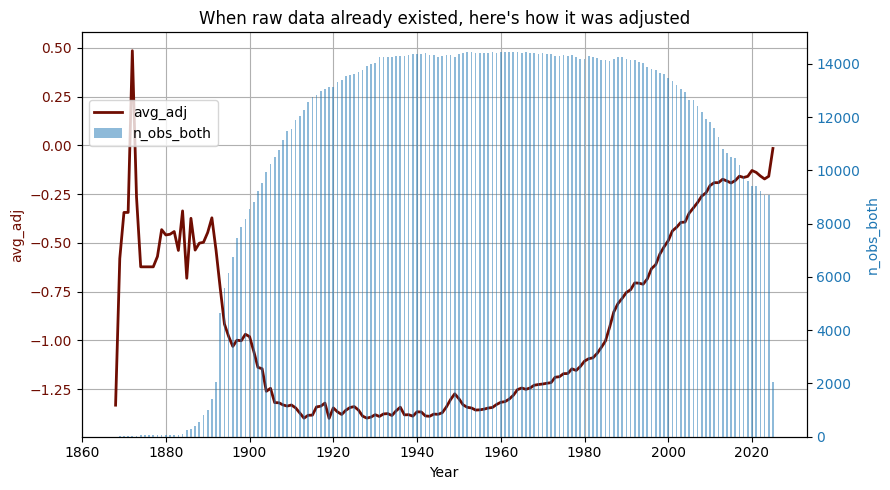

In [12]:
make_chart(stats, 'avg_adj', 'n_obs_both', "When raw data already existed, here's how it was adjusted")

### When raw data did not exist, here's how it was estimated

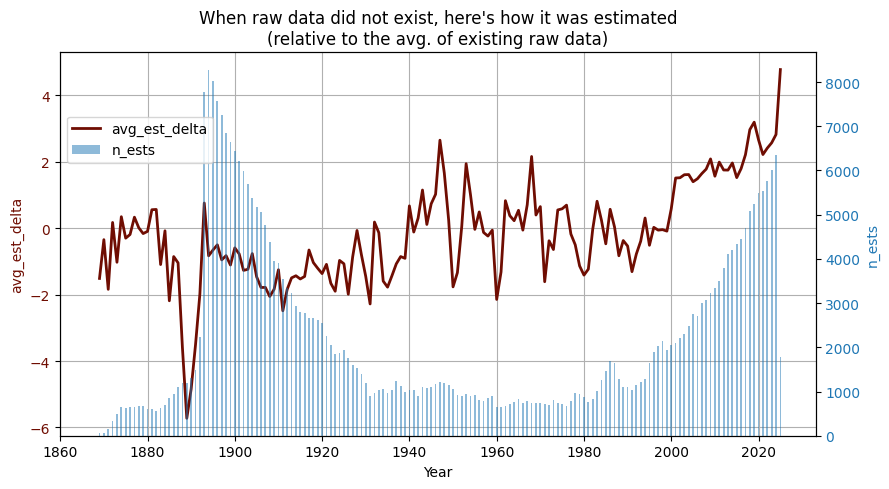

In [14]:
make_chart(stats, 'avg_est_delta', 'n_ests', "When raw data did not exist, here's how it was estimated\n(relative to the avg. of existing raw data)")